# Privatizing Histograms

Sometimes we want to release the counts of individual outcomes in a dataset.
When plotted, this makes a histogram.

The library currently has two approaches:

1. Known category set `make_count_by_categories`
2. Unknown category set `make_count_by`

The next code block imports handles boilerplate: imports, data loading, plotting.

In [1]:
import opendp.prelude as dp
dp.enable_features("contrib", "floating-point")
max_influence = 1
budget = (1., 1e-8)

# public information
col_names = ["age", "sex", "educ", "race", "income", "married"]
size = 1000

data = dp.examples.get_california_pums_path().read_text()

def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    plt.ylim([0,225])
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xlim(0,15)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')
    ax.legend()
    plt.title('Histogram of Education Level')
    plt.xlabel('Years of Education')
    plt.ylabel('Count')
    plt.show()

## Private histogram via `make_count_by_categories`

This approach is only applicable if the set of potential values that the data may take on is public information.
If this information is not available, then use `make_count_by` instead.
It typically has greater utility than `make_count_by` until the size of the category set is greater than dataset size.
In this data, we know that the category set is public information:
strings consisting of the numbers between 1 and 20.

The counting aggregator computes a vector of counts in the same order as the input categories.
It also includes one extra count at the end of the vector,
consisting of the number of elements that were not members of the category set.

/var/folders/lc/l1nrfls97n591dg9pb5dybzc0000gq/T/ipykernel_55551/3114099242.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) make_split_dataframe. (Use Polars instead) -- Deprecated since version 0.12.0.
  dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
/var/folders/lc/l1nrfls97n591dg9pb5dybzc0000gq/T/ipykernel_55551/3114099242.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) make_select_column. (Use Polars instead) -- Deprecated since version 0.12.0.
  dp.t.make_select_column(key="educ", TOA=str) >>


Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0]
DP Educational level counts:
 [33, 17, 38, 17, 24, 21, 31, 50, 200, 60, 165, 75, 177, 55, 24, 16, 2, 4, -1]
DP estimate for the number of records that were not a member of the category set: 1


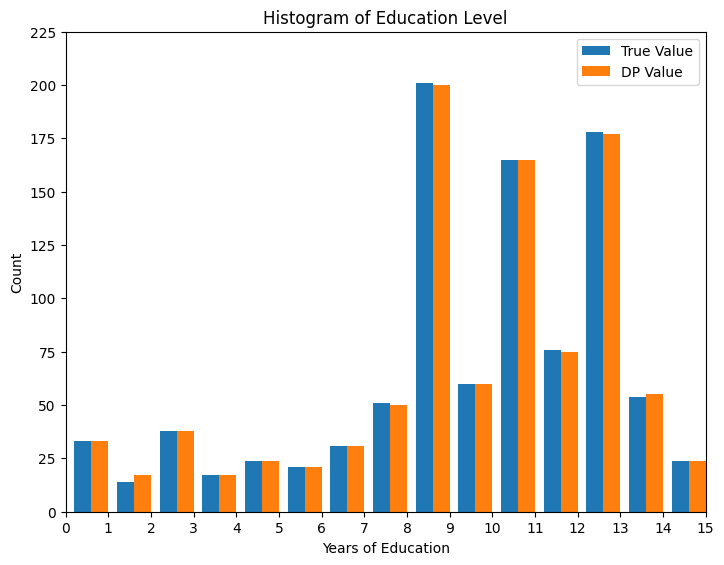

In [2]:
# public information
categories = list(map(str, range(1, 20)))

histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="educ", TOA=str) >>
    # Compute counts for each of the categories and null
    dp.t.then_count_by_categories(categories=categories)
)

noisy_histogram = dp.binary_search_chain(
    lambda s: histogram >> dp.m.then_laplace(scale=s),
    d_in=max_influence, d_out=budget[0])

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)

print("Educational level counts:\n", sensitive_counts[:-1])
print("DP Educational level counts:\n", released_counts[:-1])

print("DP estimate for the number of records that were not a member of the category set:", released_counts[-1])

plot_histogram(sensitive_counts, released_counts)

## Private histogram via `make_count_by` and `make_laplace_threshold`
This approach is applicable when the set of categories is unknown or very large.
The `make_count_by` transformation computes a hashmap containing the count of each unique key,
and `make_laplace_threshold` adds noise to the counts and censors counts less than some threshold.

On `make_laplace_threshold`, the noise scale parameter influences the epsilon parameter of the budget, 
and the threshold influences the delta parameter in the budget.
Any category with a count sufficiently small is censored from the release.

It is sometimes referred to as a "stability histogram" because it only releases counts for "stable" categories that exist in all datasets that are considered "neighboring" to your private dataset.

I start out by defining a function that finds the tightest noise scale and threshold for which the stability histogram is `(d_in, d_out)`-close.

In [3]:
def make_laplace_threshold_budget(
    preprocess: dp.Transformation,
    d_in, d_out
) -> dp.Measurement:
    """Make a stability histogram that respects a given d_in, d_out."""
    def privatize(s, t=100_000):
        return preprocess >> dp.m.then_laplace_threshold(scale=s, threshold=t)
    
    s = dp.binary_search(lambda s: privatize(s=s).map(d_in)[0] <= d_out[0])
    t = dp.binary_search(lambda t: privatize(s=s, t=t).map(d_in)[1] <= d_out[1], T=int)

    return privatize(s=s, t=t)

I now use the `make_laplace_threshold_budget` constructor to release a private histogram on the education data.

/var/folders/lc/l1nrfls97n591dg9pb5dybzc0000gq/T/ipykernel_55551/1471925572.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) make_split_dataframe. (Use Polars instead) -- Deprecated since version 0.12.0.
  dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
/var/folders/lc/l1nrfls97n591dg9pb5dybzc0000gq/T/ipykernel_55551/1471925572.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) make_select_column. (Use Polars instead) -- Deprecated since version 0.12.0.
  dp.t.make_select_column(key="educ", TOA=str) >>


Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0, 0]
DP Educational level counts:
 {'15': 24, '13': 178, '6': 20, '9': 203, '11': 164, '14': 53, '12': 75, '1': 35, '7': 32, '5': 25, '3': 38, '10': 59, '8': 49}


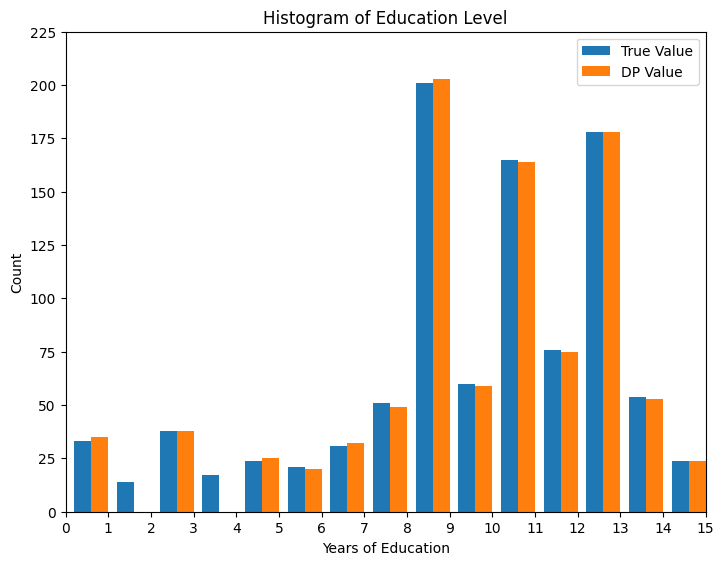

In [4]:
preprocess = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="educ", TOA=str) >>
    dp.t.then_count_by()
)

noisy_histogram = make_laplace_threshold_budget(
    preprocess,
    d_in=max_influence, d_out=budget)

sensitive_counts = histogram(data)
released_counts = noisy_histogram(data)
# postprocess to make the results easier to compare
postprocessed_counts = {k: round(v) for k, v in released_counts.items()}

print("Educational level counts:\n", sensitive_counts)
print("DP Educational level counts:\n", postprocessed_counts)

def as_array(data):
    return [data.get(k, 0) for k in categories]

plot_histogram(sensitive_counts, as_array(released_counts))